Goal: Building a model to predict both an individual's  **sex** and their **ADHD** diagnosis using socio-demographic, emotions and parenting information

In [1]:
pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.multioutput import MultiOutputClassifier
import umap
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/widsdatathon2025/SAMPLE_SUBMISSION.xlsx
/kaggle/input/widsdatathon2025/Data Dictionary.xlsx
/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv
/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAINING_SOLUTIONS.xlsx
/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAIN_CATEGORICAL_METADATA.xlsx
/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAIN_QUANTITATIVE_METADATA.xlsx
/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx
/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv
/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx
/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx
/kaggle/input/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv
/kaggle/input/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx
/kaggle/input/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx


In [3]:
#Load File
sample_submission = pd.read_excel('/kaggle/input/widsdatathon2025/SAMPLE_SUBMISSION.xlsx')
data_dict = pd.read_excel('/kaggle/input/widsdatathon2025/Data Dictionary.xlsx')
train_sol = pd.read_excel('/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx')
train_cat = pd.read_excel('/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAIN_CATEGORICAL_METADATA.xlsx')
train_quant = pd.read_excel('/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAIN_QUANTITATIVE_METADATA.xlsx')
funct_connect = pd.read_csv('/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
train_cat = pd.read_excel('/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx')
test_quant = pd.read_excel('/kaggle/input/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx')
test_cat = pd.read_excel('/kaggle/input/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx')
funct_test_connect = pd.read_csv('/kaggle/input/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')

In [4]:
data_dict

,DataType,Instrument,Field,Description,Type,Labels
0,QUANTITATIVE METADATA,NaN,NaN,NaN,NaN,NaN
1,NaN,Identifier,participant_id,Participant ID,str,NaN
2,Quantitative,Edinburgh Handedness Questionnaire,EHQ_EHQ_Total,Laterality Index (Score),float,-100 = 10th left\n−28 ≤ LI < 48 = middle\n100 ...
3,Quantitative,Ishihara Color Vision Test,ColorVision_CV_Score,Color vision test score,int,NaN
4,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_CP,Corporal Punishment Score,int,NaN
5,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_ID,Inconsistent Discipline Score,int,NaN
6,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_INV,Involvement Score,int,NaN
7,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_OPD,Other Discipline Practices Score (Not factored...,int,NaN
8,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PM,Poor Monitoring/Supervision Score,int,NaN
9,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PP,Positive Parenting Score,int,NaN


In [5]:
funct_connect

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.222930,0.527903,0.429966,0.060457,0.566489,0.315342,0.508408,-0.078290,0.525692,...,0.224985,0.397448,0.422966,0.184642,0.305549,0.420349,0.016328,0.561864,0.471170,0.365221
1,WHWymJu6zNZi,0.614765,0.577255,0.496127,0.496606,0.404686,0.439724,0.122590,-0.085452,0.120673,...,0.217546,-0.014549,0.000440,-0.096451,0.454501,0.343916,0.167313,0.607656,0.550623,0.503176
2,4PAQp1M6EyAo,-0.116833,0.458408,0.260703,0.639031,0.769337,0.442528,0.637110,0.192010,0.520379,...,0.342487,-0.021141,-0.037836,0.075069,0.412712,0.292708,0.391005,0.461544,0.508912,0.624232
3,obEacy4Of68I,0.199688,0.752714,0.658283,0.575096,0.692867,0.645789,0.522750,0.412188,0.530843,...,0.103562,-0.178313,0.210983,-0.018666,0.436313,0.592982,0.216205,0.341272,0.440313,0.558193
4,s7WzzDcmDOhF,0.227321,0.613268,0.621447,0.562673,0.736709,0.589813,0.266676,0.359668,0.300771,...,-0.164956,0.007064,-0.120904,-0.488095,0.493575,-0.215361,0.210685,0.055850,0.119065,0.108273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,9gpepMI9sj5q,0.265284,0.551726,0.628318,0.647700,0.710757,0.132334,0.326207,0.354319,0.531170,...,0.127097,0.129787,0.298987,0.114577,0.534109,0.118893,0.181292,0.181055,0.238357,0.577009
1209,FIDen5rdMc0v,-0.018377,0.576689,0.527451,0.327463,0.586868,0.573689,0.300544,0.301103,0.659840,...,0.482214,-0.159587,-0.162498,-0.093249,0.309914,0.143818,0.218337,0.389331,0.328741,0.238443
1210,dlsMC4TXL4e8,0.227028,0.405659,0.023545,-0.093085,-0.068960,0.647574,0.762552,0.465109,0.199337,...,-0.379304,0.126976,0.193695,0.214483,0.429836,0.302141,0.104774,0.856375,0.303248,0.363639
1211,syeyZjEx8FUx,0.189849,0.752876,0.842463,0.817037,0.820196,0.792950,0.650929,0.488504,0.580207,...,-0.212254,-0.055539,-0.221935,-0.202464,0.602651,0.482066,0.399363,0.373746,0.279900,0.684434


In [6]:
train_sol

,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1
...,...,...,...
1208,Atx7oub96GXS,0,0
1209,groSbUfkQngM,0,1
1210,zmxGvIrOD0bt,0,1
1211,rOmWFuJCud5G,0,0


In [7]:
train_cat

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN
3,05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0
4,06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1208,zwjJWCRzKhDz,2019,4,1.0,1.0,3.0,12.0,NaN,15.0,5.0
1209,zwXD5v17Rx01,2018,1,0.0,0.0,3.0,21.0,40.0,21.0,40.0
1210,zWzLCi3NTBTd,2018,3,2.0,3.0,3.0,21.0,40.0,21.0,35.0
1211,Zy9GTHDxUbXU,2019,4,0.0,1.0,3.0,18.0,35.0,18.0,45.0


In [8]:
train_cat.isnull().sum()

participant_id                        0
Basic_Demos_Enroll_Year               0
Basic_Demos_Study_Site                0
PreInt_Demos_Fam_Child_Ethnicity     43
PreInt_Demos_Fam_Child_Race          54
MRI_Track_Scan_Location               3
Barratt_Barratt_P1_Edu               15
Barratt_Barratt_P1_Occ               31
Barratt_Barratt_P2_Edu              198
Barratt_Barratt_P2_Occ              222
dtype: int64

In [9]:
for col in train_cat:
    num_unique = train_cat[col].nunique()
    print(f"{col} has {num_unique} unique categories")
    print(f"\n Value Counts in {col}: \n{train_cat[col].value_counts()}")

participant_id has 1213 unique categories

 Value Counts in participant_id: 
participant_id
00aIpNTbG5uh    1
PLSPsExmUXmN    1
piMqm35FzuKu    1
Pi59C4uUGauF    1
PFQTomzEXBwj    1
               ..
Fiw9NzfhWBQT    1
FIDen5rdMc0v    1
fI8YJXqTB0P7    1
fHYpxTrLLJp0    1
Zye7yYRQohXi    1
Name: count, Length: 1213, dtype: int64
Basic_Demos_Enroll_Year has 6 unique categories

 Value Counts in Basic_Demos_Enroll_Year: 
Basic_Demos_Enroll_Year
2018    415
2019    312
2017    254
2016    191
2015     36
2020      5
Name: count, dtype: int64
Basic_Demos_Study_Site has 4 unique categories

 Value Counts in Basic_Demos_Study_Site: 
Basic_Demos_Study_Site
1    652
3    430
4    120
2     11
Name: count, dtype: int64
PreInt_Demos_Fam_Child_Ethnicity has 4 unique categories

 Value Counts in PreInt_Demos_Fam_Child_Ethnicity: 
PreInt_Demos_Fam_Child_Ethnicity
0.0    777
1.0    296
2.0     77
3.0     20
Name: count, dtype: int64
PreInt_Demos_Fam_Child_Race has 10 unique categories

 Value Counts 

In [10]:
train_quant

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,UmrK0vMLopoR,40.00,13,3,10,47,13,11,28,0,6,1,5,0,5,1,0,10,NaN
1,CPaeQkhcjg7d,-94.47,14,3,13,34,18,23,30,0,18,6,8,7,8,10,4,5,NaN
2,Nb4EetVPm3gs,-46.67,14,4,10,35,16,10,29,1,14,2,8,5,7,6,4,9,8.239904
3,p4vPhVu91o4b,-26.68,10,5,12,39,19,16,28,6,24,4,16,9,10,8,4,6,NaN
4,M09PXs7arQ5E,0.00,14,5,15,40,20,24,28,1,18,4,11,4,10,7,3,9,8.940679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,Atx7oub96GXS,87.80,14,5,14,39,20,15,21,1,9,2,7,3,6,2,0,9,10.697923
1209,groSbUfkQngM,77.80,14,3,10,32,20,11,23,6,18,3,11,9,5,7,4,7,13.964750
1210,zmxGvIrOD0bt,16.68,14,3,16,28,15,19,27,3,4,1,3,0,0,1,0,10,NaN
1211,rOmWFuJCud5G,53.40,14,3,14,34,18,23,23,4,9,0,9,3,5,0,0,9,12.089094


In [11]:
train_quant.describe()

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,853.000000
mean,58.876917,13.164880,3.781533,13.205276,39.374279,17.785655,16.393240,25.246496,2.059357,12.122836,2.307502,7.557296,4.073372,5.497939,4.565540,2.258038,7.683430,11.245678
std,49.855501,2.780624,1.376700,3.811772,6.245928,3.764112,5.376994,3.950529,2.023322,6.577207,2.167549,4.166627,2.819731,2.836764,3.519634,2.090414,2.190295,3.234372
min,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.600000,14.000000,3.000000,11.000000,36.000000,16.000000,13.000000,23.000000,0.000000,7.000000,1.000000,4.000000,2.000000,4.000000,2.000000,0.000000,6.000000,8.803901
50%,76.670000,14.000000,3.000000,13.000000,40.000000,18.000000,16.000000,26.000000,2.000000,12.000000,2.000000,7.000000,4.000000,6.000000,4.000000,2.000000,8.000000,10.739219
75%,93.400000,14.000000,4.000000,16.000000,43.000000,20.000000,19.000000,28.000000,3.000000,17.000000,4.000000,10.000000,6.000000,8.000000,7.000000,4.000000,10.000000,13.460871
max,100.000000,14.000000,12.000000,28.000000,50.000000,28.000000,37.000000,30.000000,10.000000,34.000000,10.000000,20.000000,10.000000,10.000000,17.000000,9.000000,10.000000,21.564453


In [12]:
train_quant.isnull().sum()

participant_id                  0
EHQ_EHQ_Total                   0
ColorVision_CV_Score            0
APQ_P_APQ_P_CP                  0
APQ_P_APQ_P_ID                  0
APQ_P_APQ_P_INV                 0
APQ_P_APQ_P_OPD                 0
APQ_P_APQ_P_PM                  0
APQ_P_APQ_P_PP                  0
SDQ_SDQ_Conduct_Problems        0
SDQ_SDQ_Difficulties_Total      0
SDQ_SDQ_Emotional_Problems      0
SDQ_SDQ_Externalizing           0
SDQ_SDQ_Generating_Impact       0
SDQ_SDQ_Hyperactivity           0
SDQ_SDQ_Internalizing           0
SDQ_SDQ_Peer_Problems           0
SDQ_SDQ_Prosocial               0
MRI_Track_Age_at_Scan         360
dtype: int64

In [13]:
a = train_quant.drop('participant_id',axis = 1)
a.skew()

EHQ_EHQ_Total                -1.622435
ColorVision_CV_Score         -4.006743
APQ_P_APQ_P_CP                1.571377
APQ_P_APQ_P_ID               -0.189873
APQ_P_APQ_P_INV              -2.484126
APQ_P_APQ_P_OPD              -0.906061
APQ_P_APQ_P_PM                0.588060
APQ_P_APQ_P_PP               -2.712986
SDQ_SDQ_Conduct_Problems      1.007941
SDQ_SDQ_Difficulties_Total    0.301522
SDQ_SDQ_Emotional_Problems    0.934296
SDQ_SDQ_Externalizing         0.175734
SDQ_SDQ_Generating_Impact     0.171464
SDQ_SDQ_Hyperactivity        -0.156734
SDQ_SDQ_Internalizing         0.722892
SDQ_SDQ_Peer_Problems         0.803060
SDQ_SDQ_Prosocial            -0.985461
MRI_Track_Age_at_Scan         0.543932
dtype: float64

In [14]:
merge_a = train_cat.merge(train_quant,on = 'participant_id',how = 'left')
merge_b = merge_a.merge(funct_connect,on = 'participant_id',how = 'left')
train = merge_b.merge(train_sol,on = 'participant_id',how = 'left')

In [15]:
merge_c = test_cat.merge(test_quant,on = 'participant_id',how = 'left')
test = merge_c.merge(funct_test_connect,on = 'participant_id',how = 'left')

In [16]:
train.isnull().sum()

participant_id                       0
Basic_Demos_Enroll_Year              0
Basic_Demos_Study_Site               0
PreInt_Demos_Fam_Child_Ethnicity    43
PreInt_Demos_Fam_Child_Race         54
                                    ..
197throw_198thcolumn                 0
197throw_199thcolumn                 0
198throw_199thcolumn                 0
ADHD_Outcome                         0
Sex_F                                0
Length: 19930, dtype: int64

In [17]:
test

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,Cfwaf5FX7jWK,2022,4,0.0,0.0,4,21.0,30.0,18.0,30.0,...,0.080423,-0.054581,-0.088163,-0.028574,0.444847,0.350149,-0.012601,0.665750,0.560565,0.555732
1,vhGrzmvA3Hjq,2023,4,0.0,0.0,4,21.0,45.0,NaN,30.0,...,0.198009,-0.000724,0.083122,0.033043,0.687497,0.306229,0.717485,0.461809,0.559632,0.350027
2,ULliyEXjy4OV,2022,4,0.0,0.0,4,21.0,40.0,18.0,40.0,...,0.051319,0.023630,-0.056819,0.117396,0.576086,0.517831,0.527044,0.605038,0.609856,0.750987
3,LZfeAb1xMtql,2022,4,0.0,0.0,3,21.0,45.0,21.0,45.0,...,0.046183,-0.238962,0.121868,-0.260970,0.646818,0.594902,0.608156,0.595459,0.683189,0.542296
4,EnFOUv0YK1RG,2022,4,2.0,0.0,4,18.0,0.0,21.0,45.0,...,0.315734,0.002234,0.290791,0.344149,0.480214,0.539824,0.447322,0.293088,0.148529,0.539823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,UadZfjdEg7eG,2023,4,0.0,0.0,4,18.0,0.0,18.0,35.0,...,0.021524,-0.162832,0.105546,0.028975,0.576180,0.378365,0.399277,0.556115,0.490833,0.568742
300,IUEHiLmQAqCi,2023,4,0.0,1.0,3,18.0,35.0,21.0,40.0,...,0.044974,-0.078047,-0.118271,0.035741,0.640073,0.515096,0.206462,0.536001,0.318518,0.305596
301,cRySmCadYFRO,2023,4,0.0,8.0,4,21.0,25.0,15.0,NaN,...,0.145582,0.004455,0.134574,-0.152951,0.782938,0.737555,0.593972,0.734463,0.680979,0.678973
302,E3MvDUtJadc5,2022,4,0.0,8.0,4,21.0,0.0,21.0,45.0,...,0.036169,-0.345563,-0.165280,-0.347035,0.657024,0.590523,0.094565,0.727339,0.429694,0.530238


In [18]:
train.describe()

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,EHQ_EHQ_Total,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
count,1213.000000,1213.000000,1170.000000,1159.000000,1210.000000,1198.000000,1182.000000,1015.000000,991.000000,1213.000000,...,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000
mean,2017.652102,2.014839,0.435897,2.177739,2.294215,17.862270,25.545685,16.876847,30.257316,58.876917,...,-0.037423,0.009393,0.557159,0.376624,0.370711,0.500415,0.476418,0.543181,0.685078,0.342951
std,1.122522,1.135147,0.693174,3.204782,0.750660,3.505608,16.757043,3.929558,13.901144,49.855501,...,0.205052,0.198820,0.150605,0.197995,0.191249,0.177047,0.177732,0.170237,0.464676,0.474891
min,2015.000000,1.000000,0.000000,0.000000,1.000000,3.000000,0.000000,3.000000,0.000000,-100.000000,...,-0.584162,-0.605647,-0.052284,-0.359869,-0.553067,-0.302408,-0.307228,-0.224057,0.000000,0.000000
25%,2017.000000,1.000000,0.000000,0.000000,2.000000,15.000000,5.000000,15.000000,20.000000,45.600000,...,-0.187871,-0.124404,0.469147,0.262601,0.242569,0.389078,0.367971,0.442283,0.000000,0.000000
50%,2018.000000,1.000000,0.000000,1.000000,2.000000,18.000000,30.000000,18.000000,35.000000,76.670000,...,-0.044155,0.004375,0.573840,0.391739,0.388528,0.524508,0.496103,0.566455,1.000000,0.000000
75%,2019.000000,3.000000,1.000000,2.000000,3.000000,21.000000,40.000000,21.000000,40.000000,93.400000,...,0.104526,0.146865,0.666128,0.521904,0.505970,0.630443,0.600065,0.667402,1.000000,1.000000
max,2020.000000,4.000000,3.000000,11.000000,4.000000,21.000000,45.000000,21.000000,45.000000,100.000000,...,0.630932,0.666169,0.889148,0.866371,0.828784,0.914021,0.898459,0.903364,1.000000,1.000000


In [19]:
train.isnull().sum()[train.isnull().sum()>0]

PreInt_Demos_Fam_Child_Ethnicity     43
PreInt_Demos_Fam_Child_Race          54
MRI_Track_Scan_Location               3
Barratt_Barratt_P1_Edu               15
Barratt_Barratt_P1_Occ               31
Barratt_Barratt_P2_Edu              198
Barratt_Barratt_P2_Occ              222
MRI_Track_Age_at_Scan               360
dtype: int64

In [20]:
missing_percentage = train.isnull().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0]
print(f"Missing Percentage:\n{missing_percentage.apply(lambda x: f'{x:.2f}%')}")


Missing Percentage:
PreInt_Demos_Fam_Child_Ethnicity     3.54%
PreInt_Demos_Fam_Child_Race          4.45%
MRI_Track_Scan_Location              0.25%
Barratt_Barratt_P1_Edu               1.24%
Barratt_Barratt_P1_Occ               2.56%
Barratt_Barratt_P2_Edu              16.32%
Barratt_Barratt_P2_Occ              18.30%
MRI_Track_Age_at_Scan               29.68%
dtype: object


<Axes: >

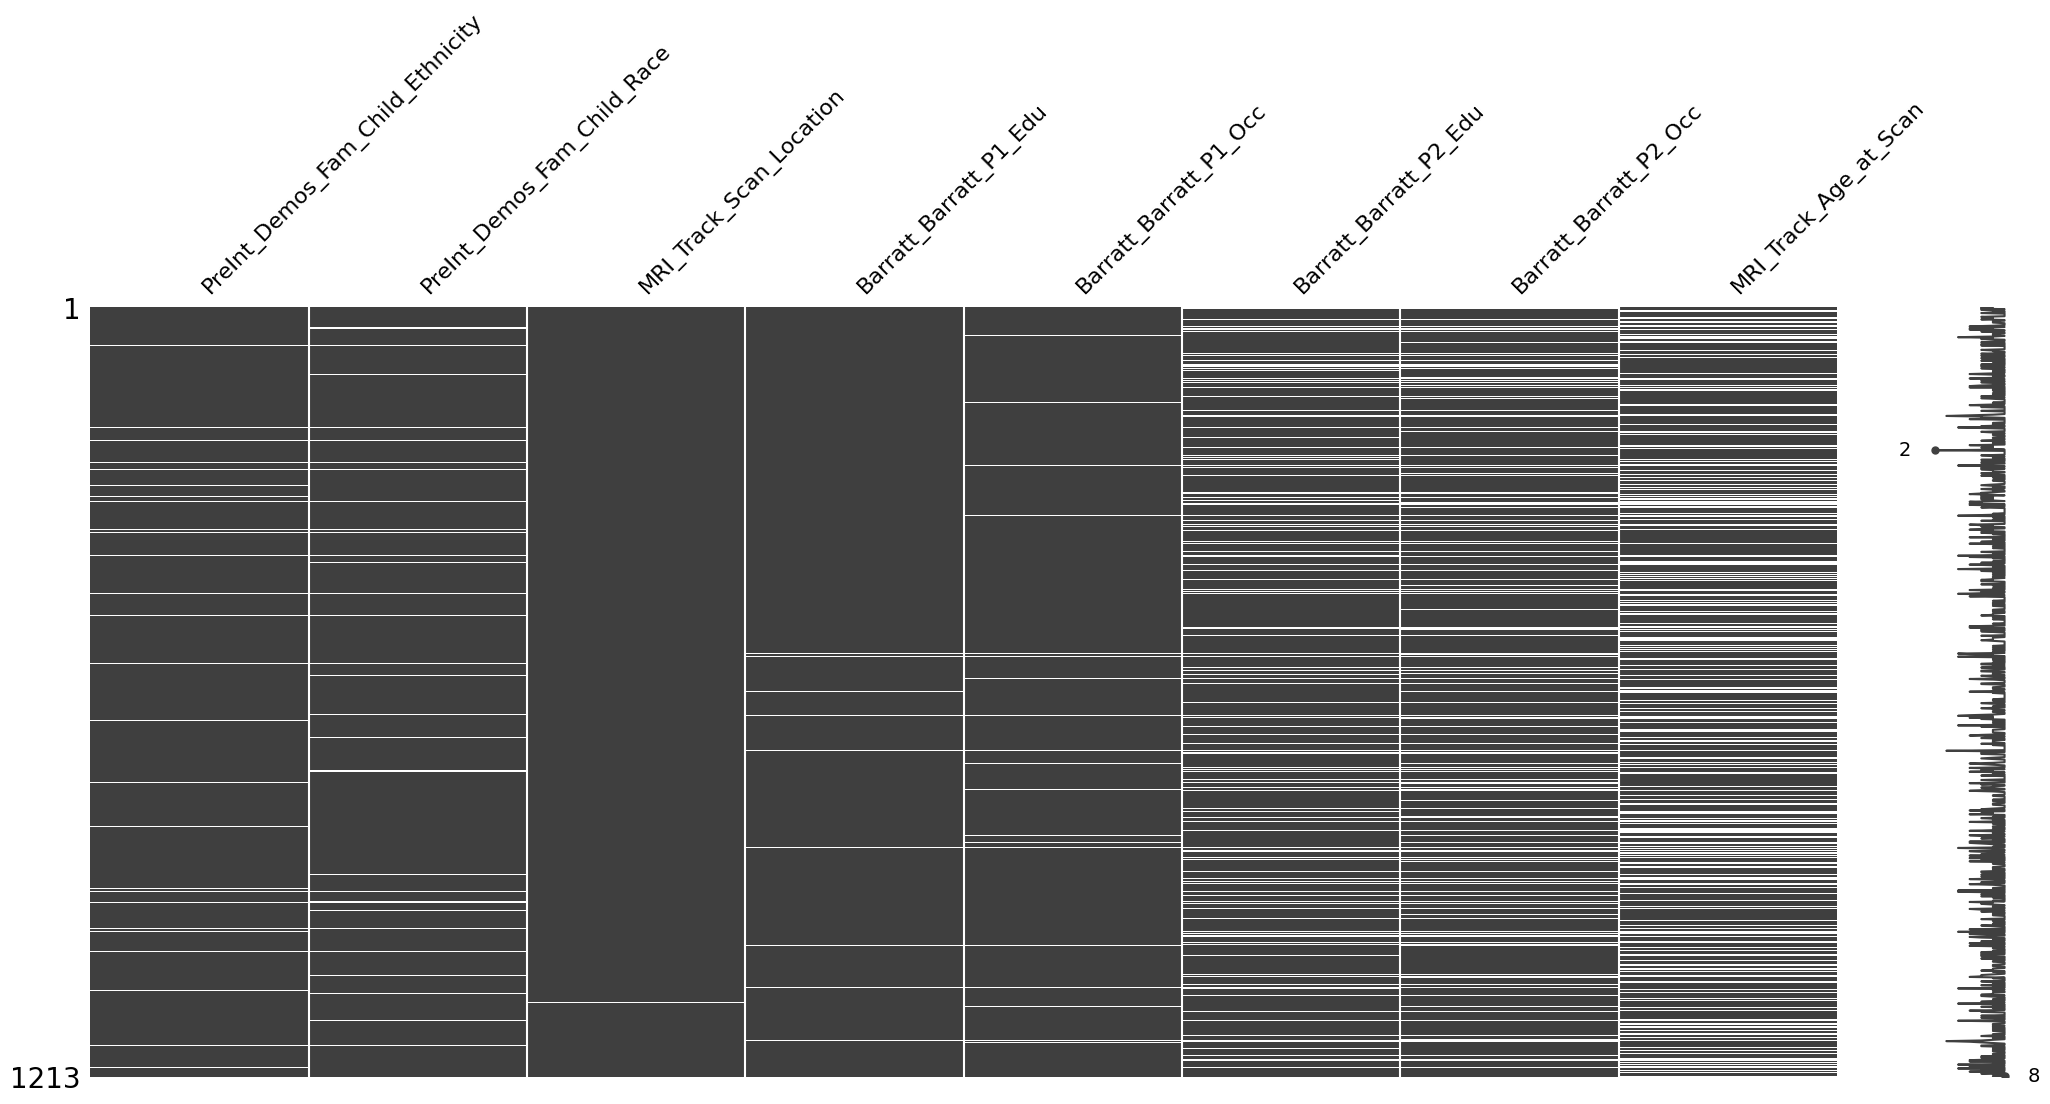

In [21]:
import missingno as msno

cols_with_missing = train.columns[train.isnull().sum()>0]
msno.matrix(train[cols_with_missing])

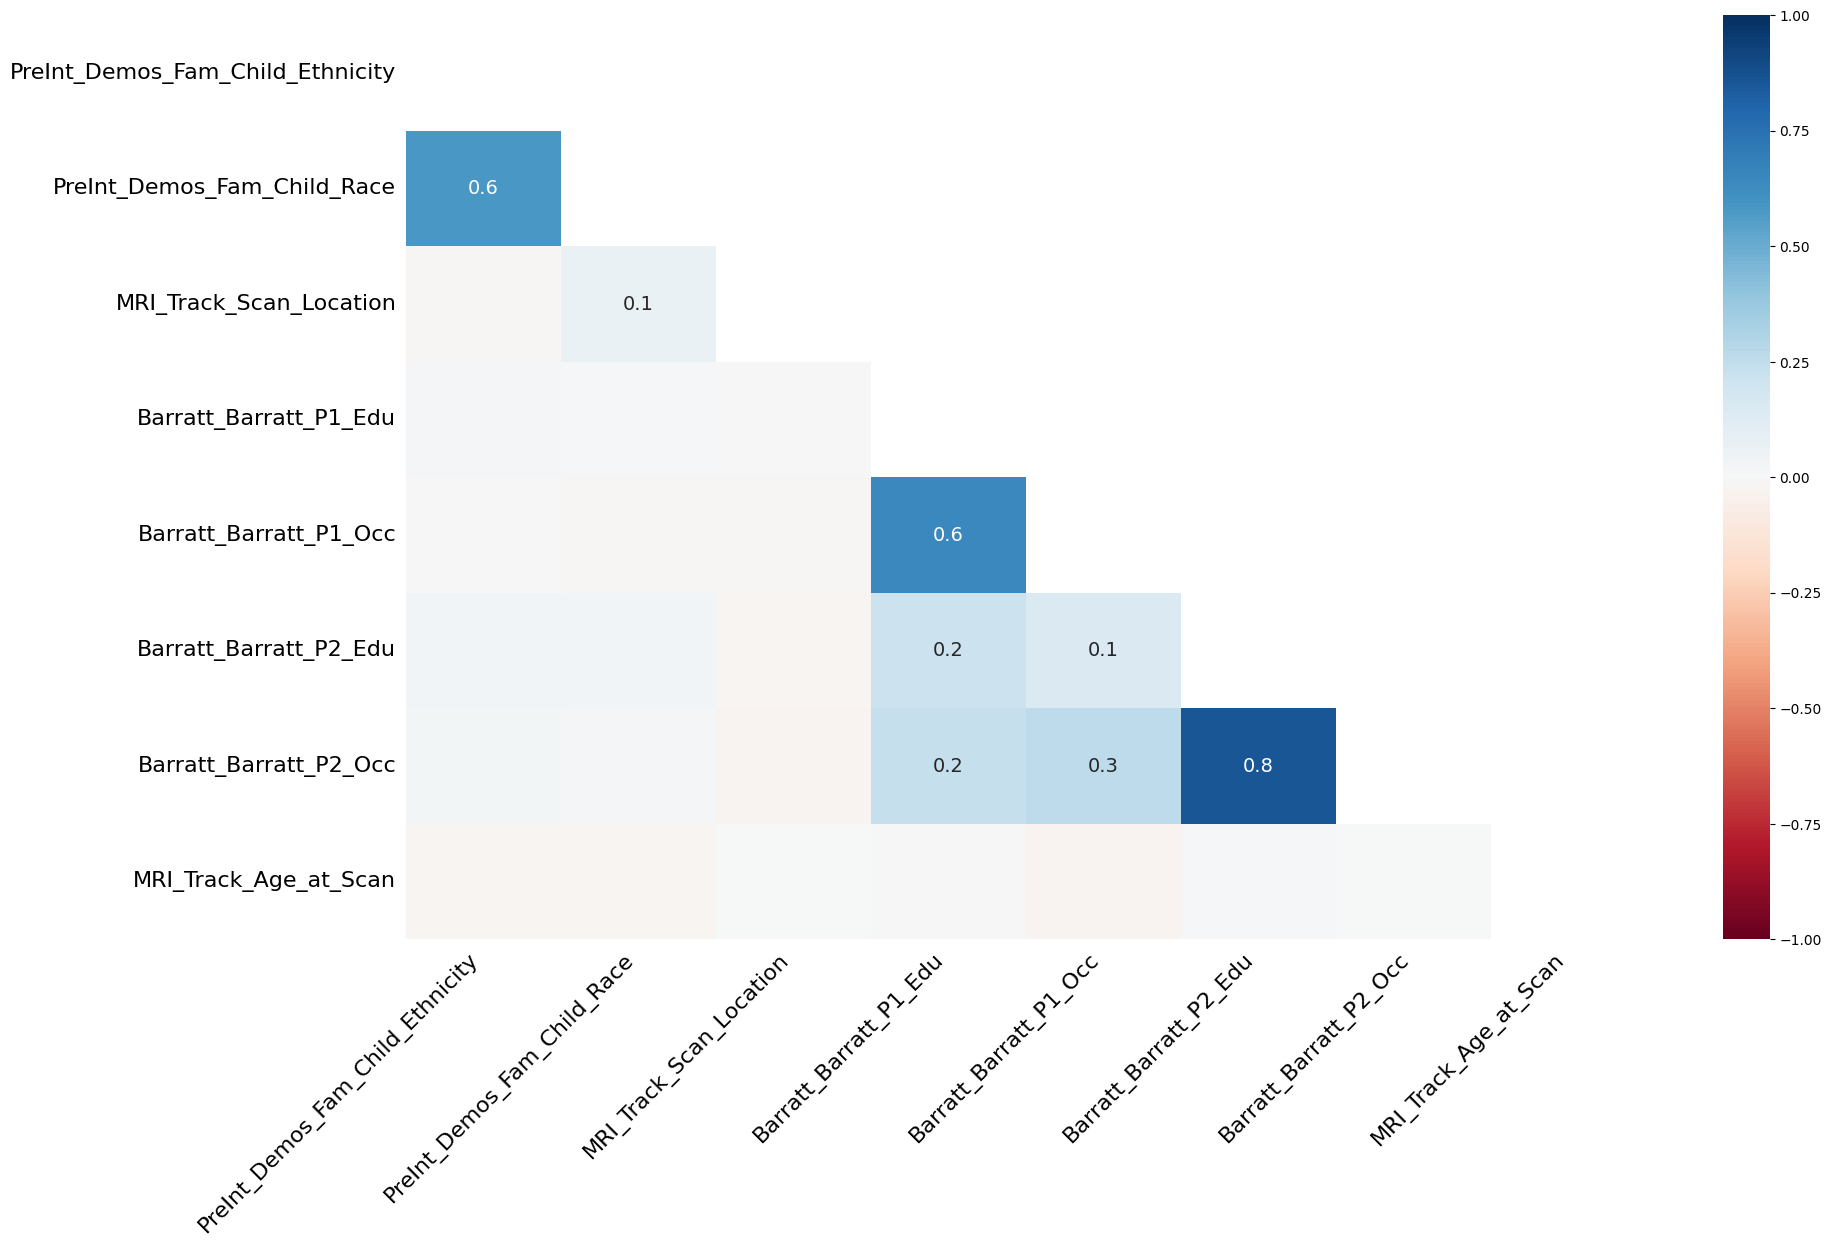

In [22]:
msno.heatmap(train[cols_with_missing])
plt.show()

Barratt_Barratt_P2_Edu and Barratt_Barratt_P2_Occ are highly correlated in missingness. This pattern suggested that the Parent 2 was not present or their information was not recorded at the time of documentations. It can considers as MNAR- Missing Not at Random. Hence, I will use 1.0 (unknown)for imputation in this case. 

In [23]:
mode_col = ["PreInt_Demos_Fam_Child_Ethnicity","PreInt_Demos_Fam_Child_Race","MRI_Track_Scan_Location"]
for col in mode_col:
    train[col].fillna(train[col].mode()[0],inplace = True)

unknown_col = na_columns = ["Barratt_Barratt_P1_Edu","Barratt_Barratt_P1_Occ","Barratt_Barratt_P2_Edu","Barratt_Barratt_P2_Occ"]
for col in unknown_col:
    train[col].fillna(1.0,inplace = True)

train["MRI_Track_Age_at_Scan"].fillna(train["MRI_Track_Age_at_Scan"].mean(), inplace=True)

train.isnull().sum()[train.isnull().sum()>0]

<ipython-input-23-7be8c258eeb1>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0],inplace = True)
<ipython-input-23-7be8c258eeb1>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

Series([], dtype: int64)

In [24]:
test.isnull().sum()[test.isnull().sum()>0]

PreInt_Demos_Fam_Child_Ethnicity     3
PreInt_Demos_Fam_Child_Race          6
Barratt_Barratt_P1_Edu               1
Barratt_Barratt_P1_Occ               1
Barratt_Barratt_P2_Edu              36
Barratt_Barratt_P2_Occ              42
EHQ_EHQ_Total                        1
ColorVision_CV_Score                 9
APQ_P_APQ_P_CP                      15
APQ_P_APQ_P_ID                      15
APQ_P_APQ_P_INV                     15
APQ_P_APQ_P_OPD                     15
APQ_P_APQ_P_PM                      15
APQ_P_APQ_P_PP                      15
SDQ_SDQ_Conduct_Problems            30
SDQ_SDQ_Difficulties_Total          30
SDQ_SDQ_Emotional_Problems          30
SDQ_SDQ_Externalizing               30
SDQ_SDQ_Generating_Impact           30
SDQ_SDQ_Hyperactivity               30
SDQ_SDQ_Internalizing               30
SDQ_SDQ_Peer_Problems               30
SDQ_SDQ_Prosocial                   30
dtype: int64

<Axes: >

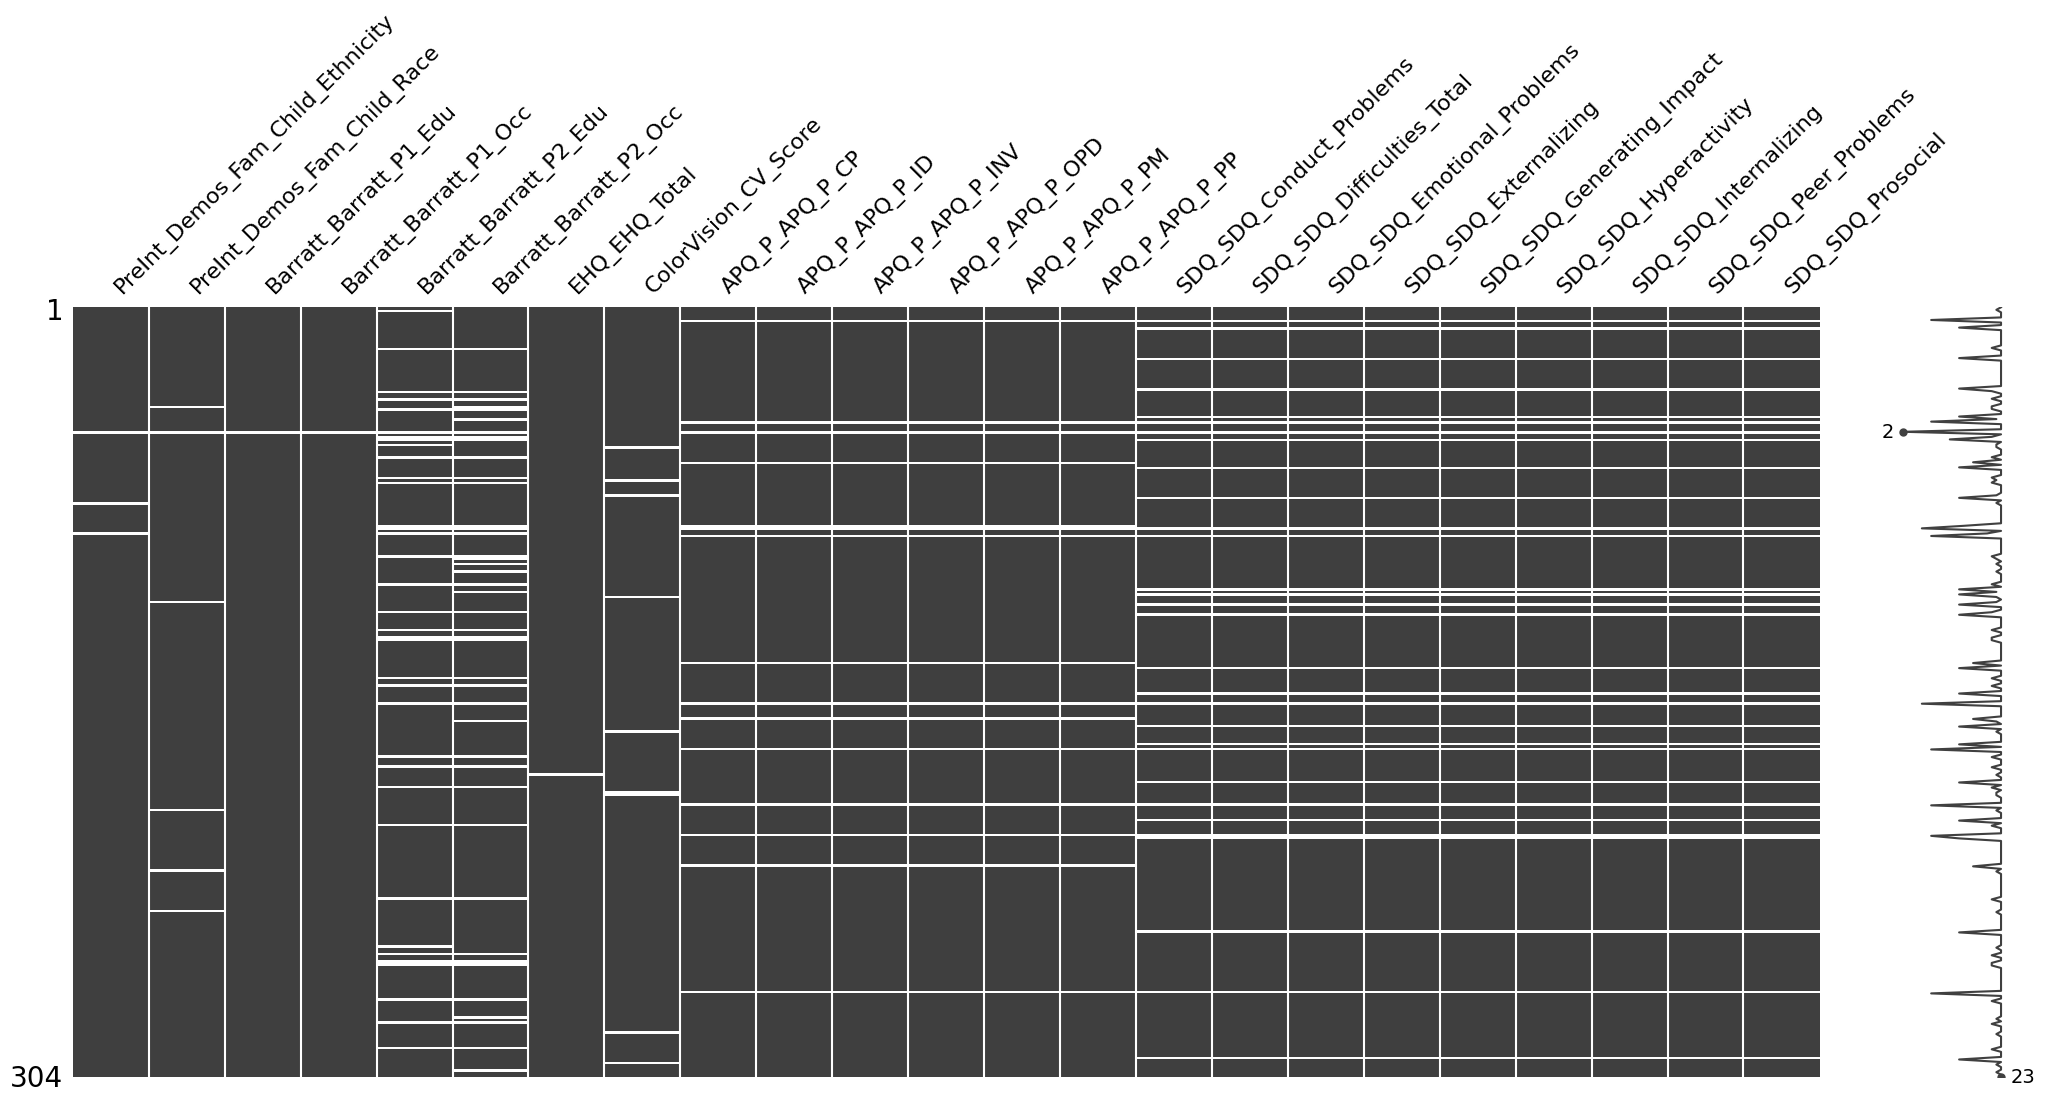

In [25]:
column_test_missing = test.columns[test.isnull().sum()>0]
msno.matrix(test[column_test_missing])

For the null values that exist in both test and training set, same method will be applied in test set. Besides that, for the test only nulls and MCAR type (EHQ_EHQ_Total and ColorVision_CV_Score), we will impute using training statistic. However, for the test only nulls and MNAR type, we will not impute it and will use tree based model to handle it.

In [26]:
# Fill na in test
mode_col = ["PreInt_Demos_Fam_Child_Ethnicity","PreInt_Demos_Fam_Child_Race",'EHQ_EHQ_Total']
for col in mode_col:
    test[col].fillna(train[col].mode()[0],inplace = True)

unknown_col = na_columns = ["Barratt_Barratt_P1_Edu","Barratt_Barratt_P1_Occ","Barratt_Barratt_P2_Edu","Barratt_Barratt_P2_Occ"]
for col in unknown_col:
    test[col].fillna(1.0,inplace = True)

test['ColorVision_CV_Score'].fillna(train['ColorVision_CV_Score'].mean(),inplace = True)

test.isnull().sum()[train.isnull().sum()>0]

<ipython-input-26-636f23c24ad4>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[col].fillna(train[col].mode()[0],inplace = True)
<ipython-input-26-636f23c24ad4>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

Series([], dtype: int64)

In [27]:
test.shape

(304, 19928)

In [28]:
df = pd.concat([train.iloc[:,0:28],train.iloc[:,-2:]],axis = 1)
df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   participant_id                    1213 non-null   object 
 1   Basic_Demos_Enroll_Year           1213 non-null   int64  
 2   Basic_Demos_Study_Site            1213 non-null   int64  
 3   PreInt_Demos_Fam_Child_Ethnicity  1213 non-null   float64
 4   PreInt_Demos_Fam_Child_Race       1213 non-null   float64
 5   MRI_Track_Scan_Location           1213 non-null   float64
 6   Barratt_Barratt_P1_Edu            1213 non-null   float64
 7   Barratt_Barratt_P1_Occ            1213 non-null   float64
 8   Barratt_Barratt_P2_Edu            1213 non-null   float64
 9   Barratt_Barratt_P2_Occ            1213 non-null   float64
 10  EHQ_EHQ_Total                     1213 non-null   float64
 11  ColorVision_CV_Score              1213 non-null   int64  
 12  APQ_P_

In [29]:
b=train_cat.columns.tolist()
b.append('ADHD_Outcome')
b.append('Sex_F')
print(b)

['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ', 'ADHD_Outcome', 'Sex_F']


In [30]:
for col in b:
   df[col]=df[col].astype(str)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   participant_id                    1213 non-null   object 
 1   Basic_Demos_Enroll_Year           1213 non-null   object 
 2   Basic_Demos_Study_Site            1213 non-null   object 
 3   PreInt_Demos_Fam_Child_Ethnicity  1213 non-null   object 
 4   PreInt_Demos_Fam_Child_Race       1213 non-null   object 
 5   MRI_Track_Scan_Location           1213 non-null   object 
 6   Barratt_Barratt_P1_Edu            1213 non-null   object 
 7   Barratt_Barratt_P1_Occ            1213 non-null   object 
 8   Barratt_Barratt_P2_Edu            1213 non-null   object 
 9   Barratt_Barratt_P2_Occ            1213 non-null   object 
 10  EHQ_EHQ_Total                     1213 non-null   float64
 11  ColorVision_CV_Score              1213 non-null   int64  
 12  APQ_P_

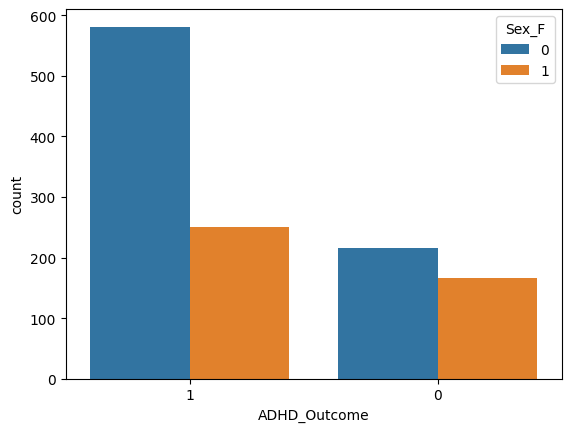

In [32]:
sns.countplot(x='ADHD_Outcome',hue='Sex_F',data =df)
plt.show()

In [33]:
df['Sex_F_ADHD'] = df['Sex_F']+ "_" +df['ADHD_Outcome']

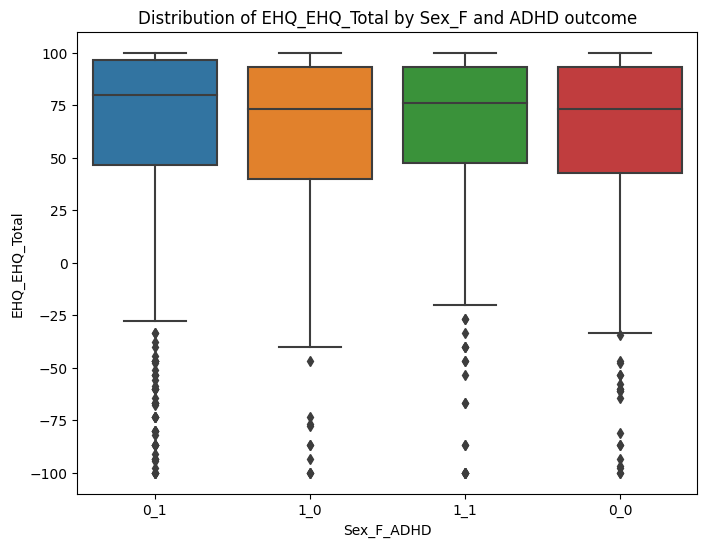

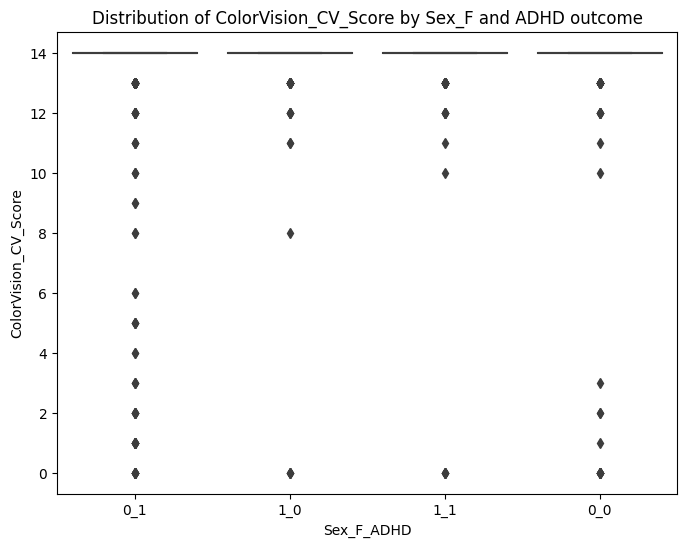

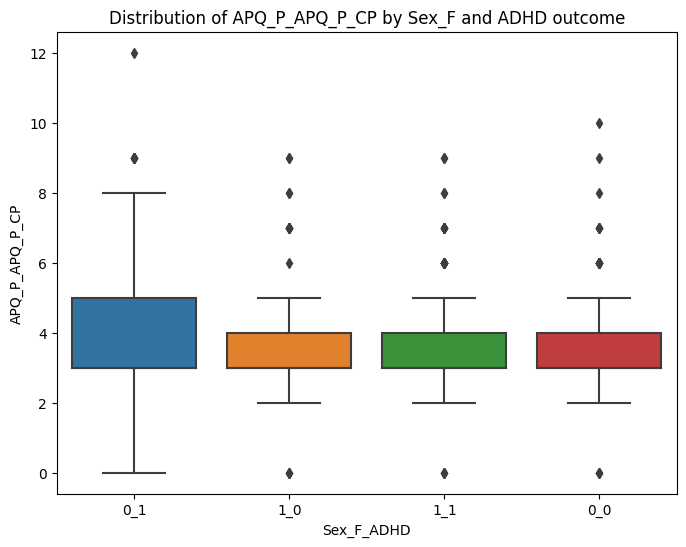

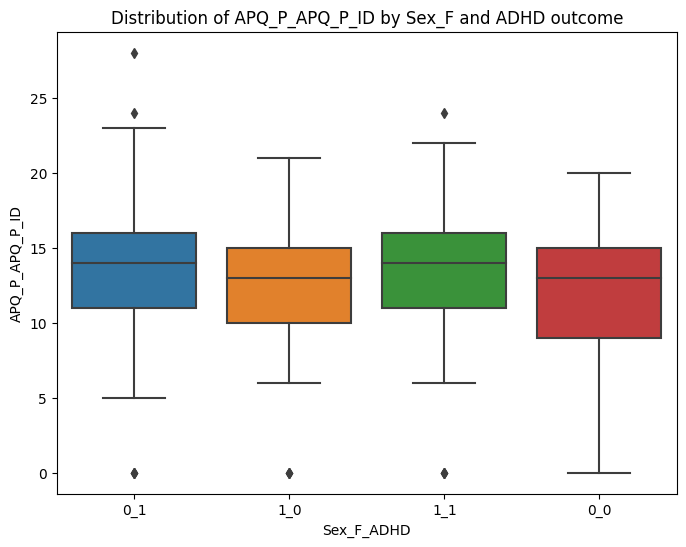

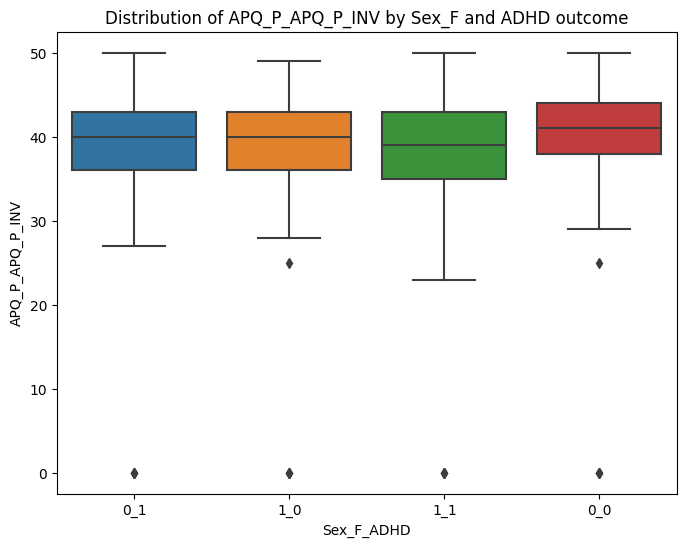

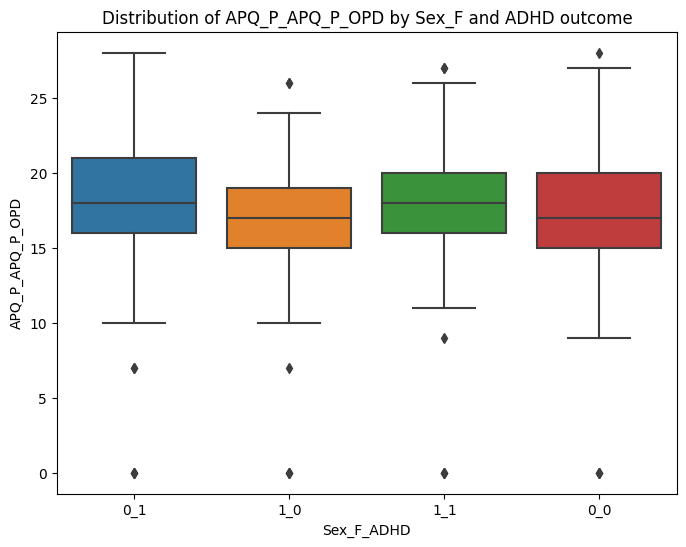

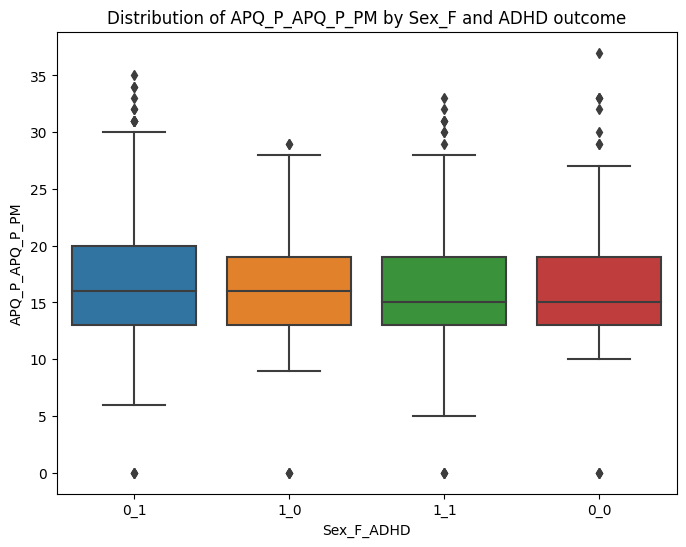

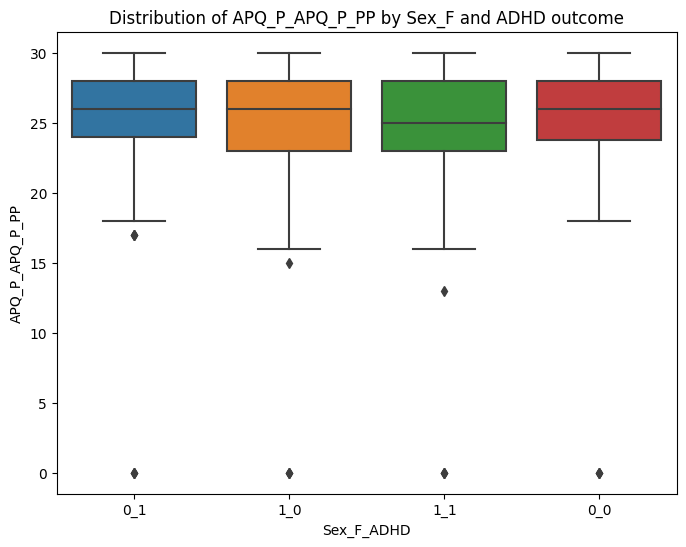

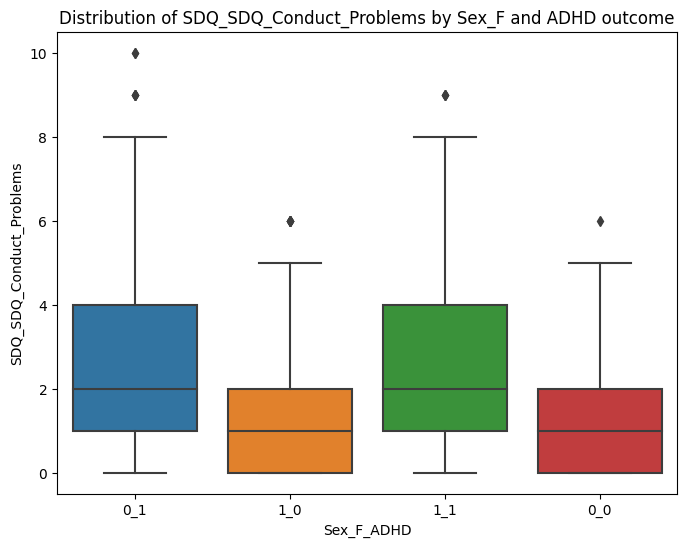

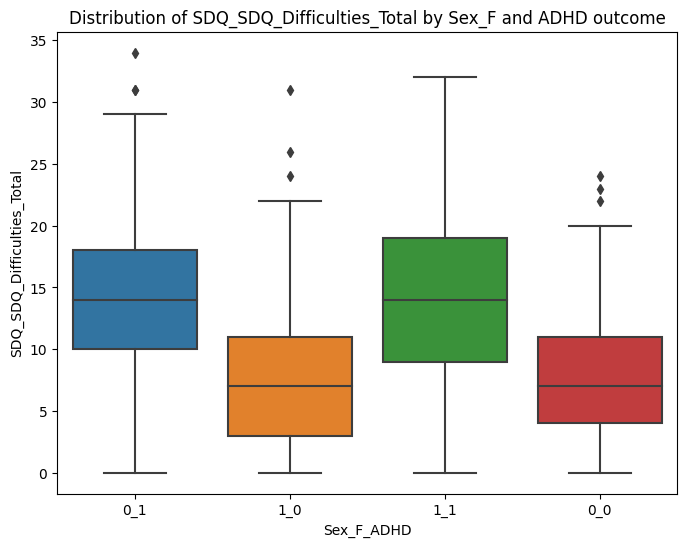

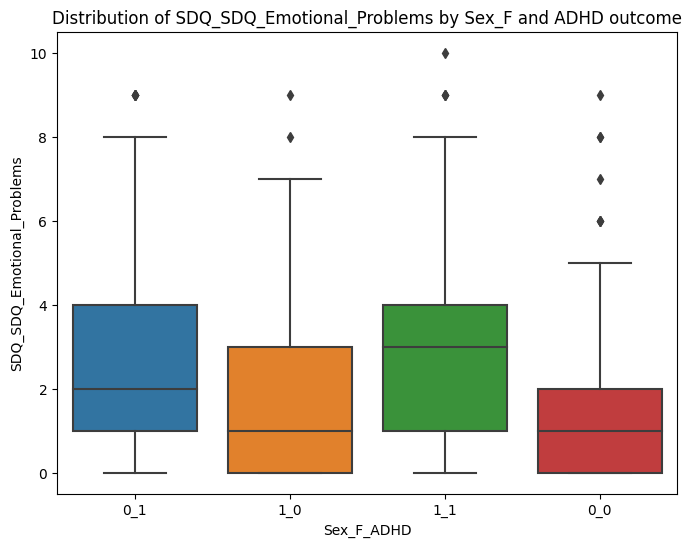

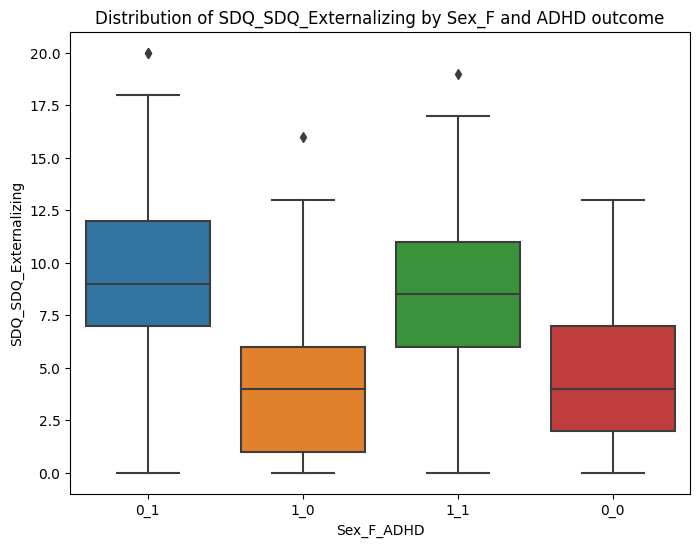

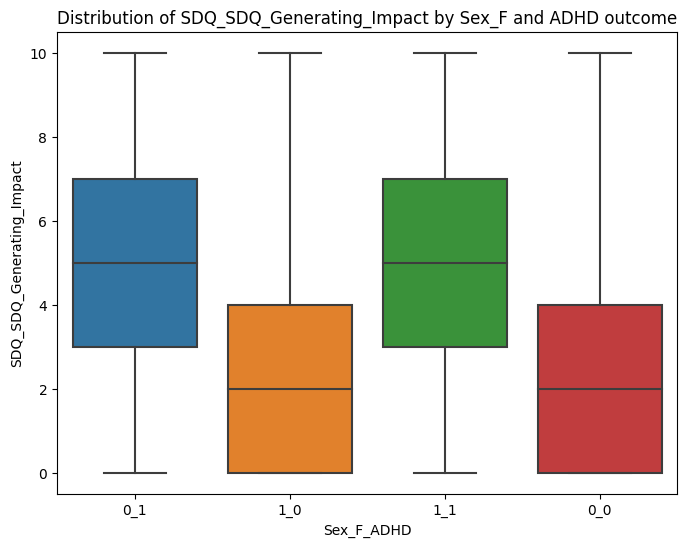

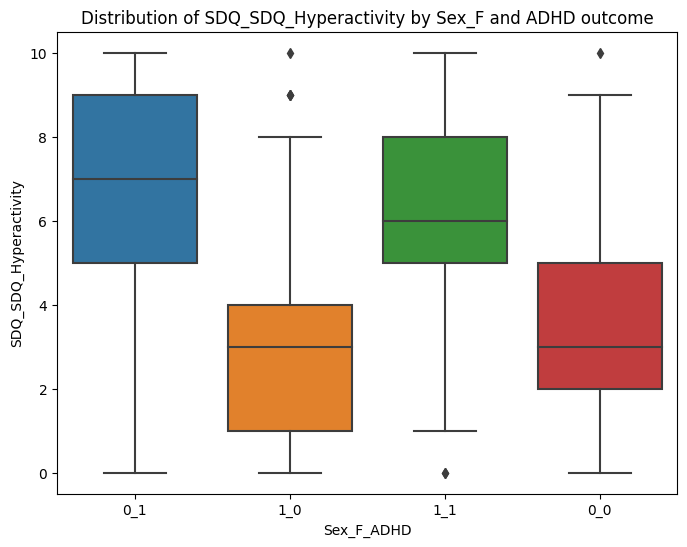

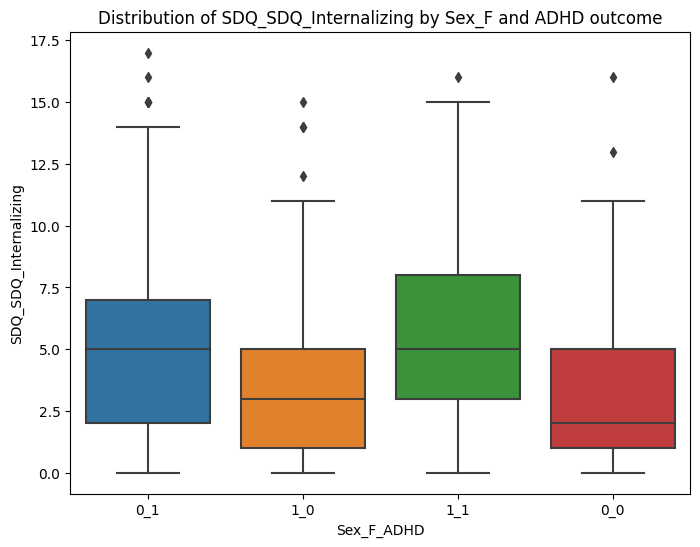

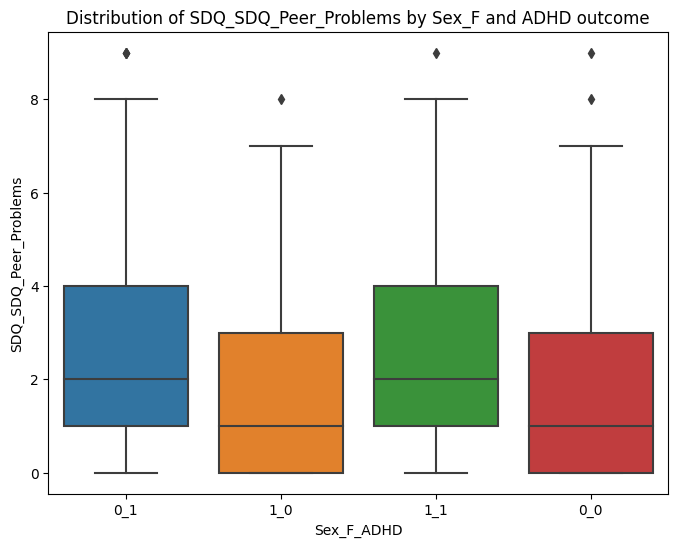

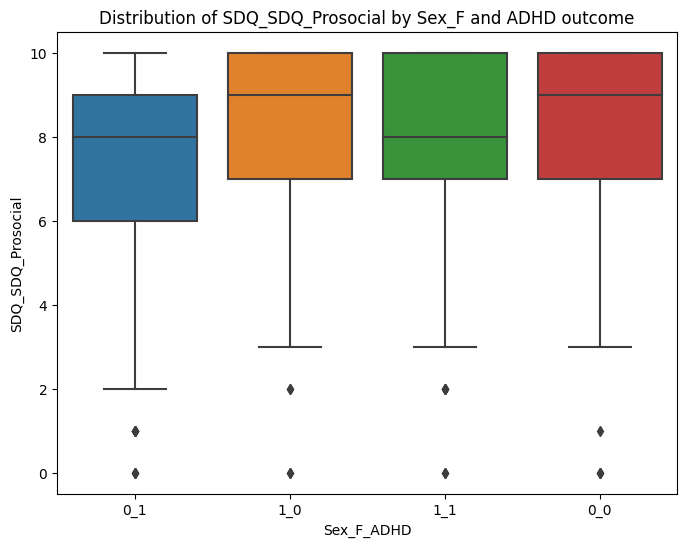

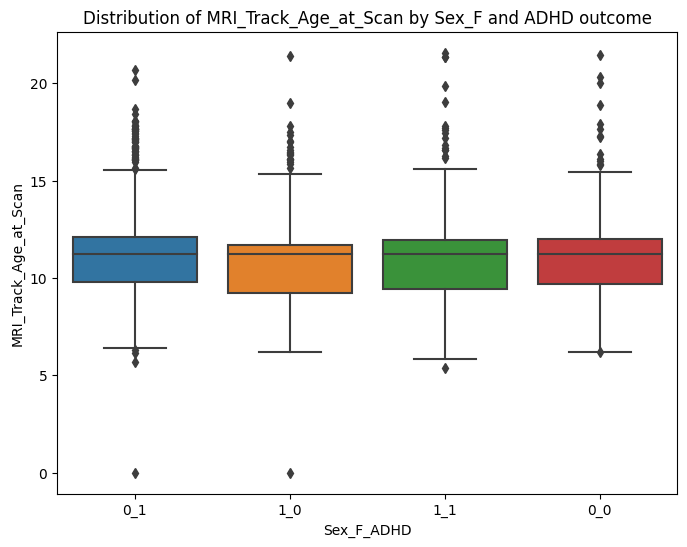

In [34]:
numerical_vars = df.select_dtypes(include=['int64','float64']).columns.tolist()

for col in numerical_vars:
    plt.figure(figsize=(8,6))
    sns.boxplot(x='Sex_F_ADHD',y=col, data=df)
    plt.title(f"Distribution of {col} by Sex_F and ADHD outcome")
    plt.show()

Based on the visualization, variables such as SDQ_Conduct_Problems, SDQ_Difficulties_Total, SDQ_Emotional_Problems, SDQ_Externalizing, SDQ_Generating_Impact, SDQ_Hyperactivity, SDQ_Internalizing, and SDQ_Peer_Problems appear to be associated with ADHD. However, they do not seem to increase the risk of ADHD specifically in females

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   participant_id                    1213 non-null   object 
 1   Basic_Demos_Enroll_Year           1213 non-null   object 
 2   Basic_Demos_Study_Site            1213 non-null   object 
 3   PreInt_Demos_Fam_Child_Ethnicity  1213 non-null   object 
 4   PreInt_Demos_Fam_Child_Race       1213 non-null   object 
 5   MRI_Track_Scan_Location           1213 non-null   object 
 6   Barratt_Barratt_P1_Edu            1213 non-null   object 
 7   Barratt_Barratt_P1_Occ            1213 non-null   object 
 8   Barratt_Barratt_P2_Edu            1213 non-null   object 
 9   Barratt_Barratt_P2_Occ            1213 non-null   object 
 10  EHQ_EHQ_Total                     1213 non-null   float64
 11  ColorVision_CV_Score              1213 non-null   int64  
 12  APQ_P_

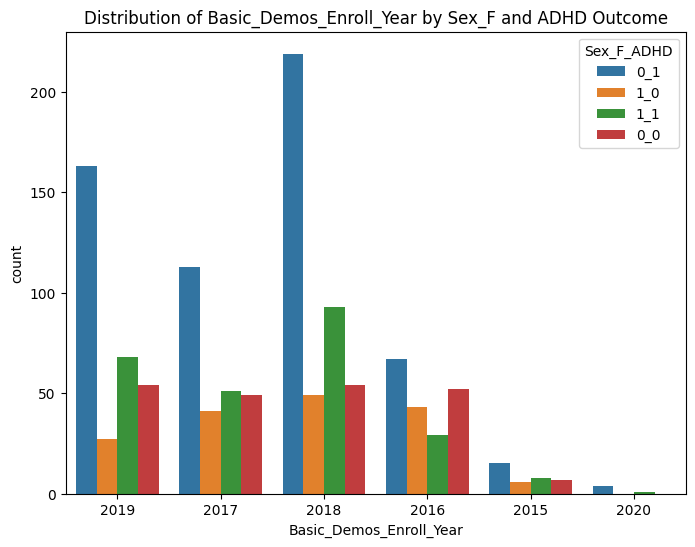

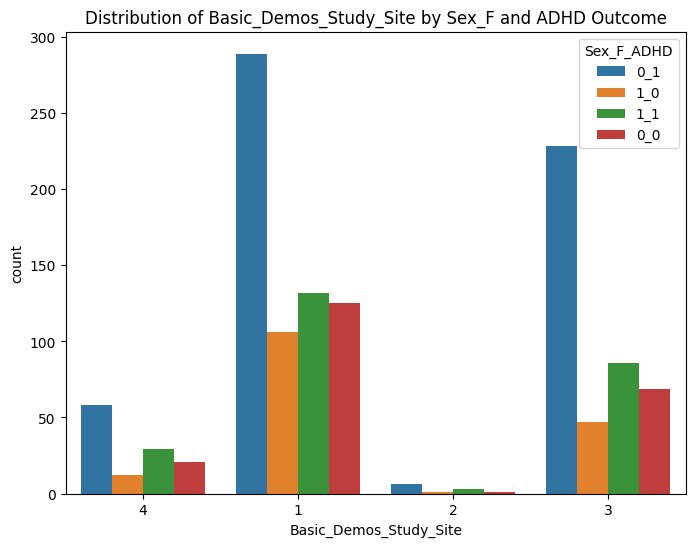

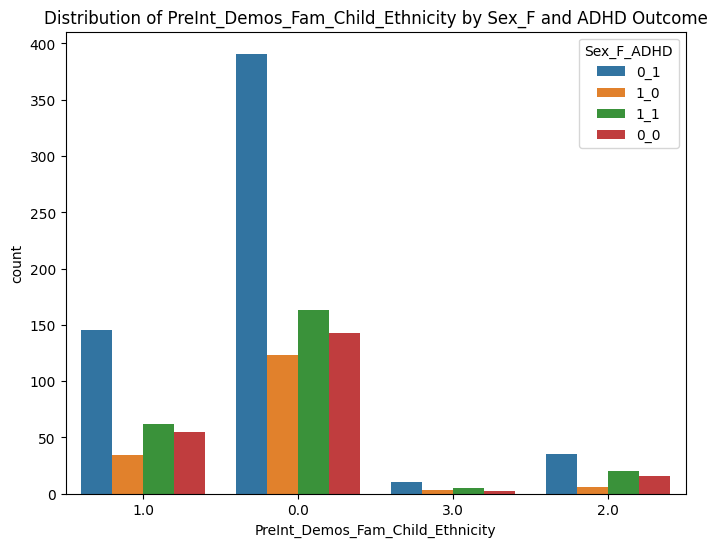

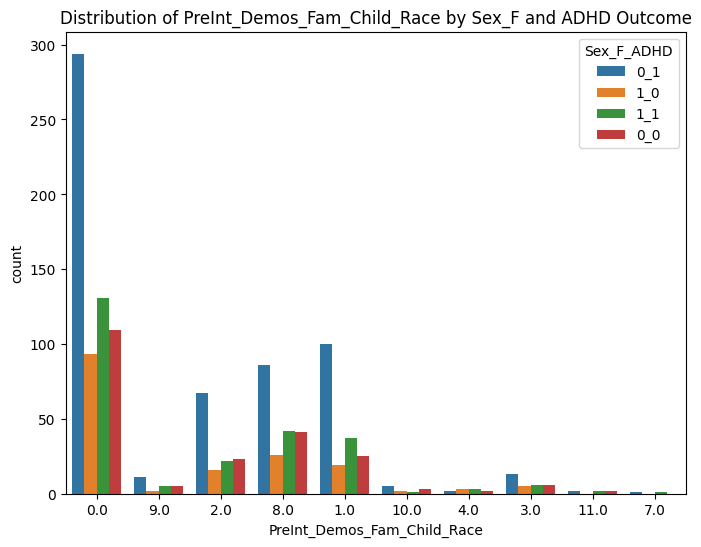

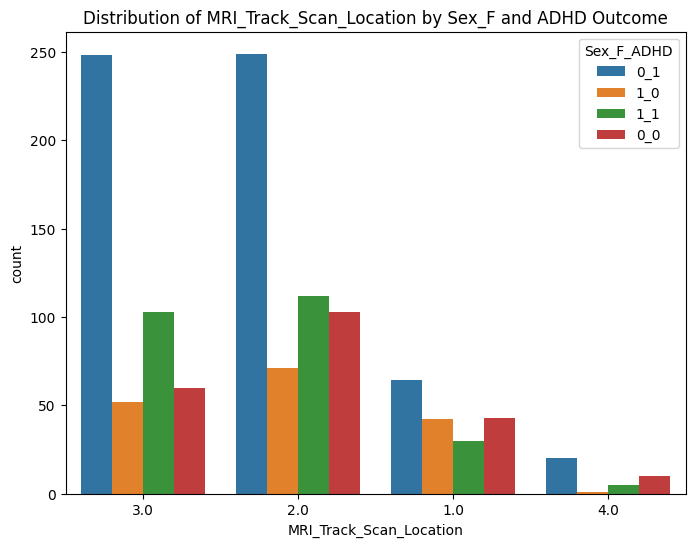

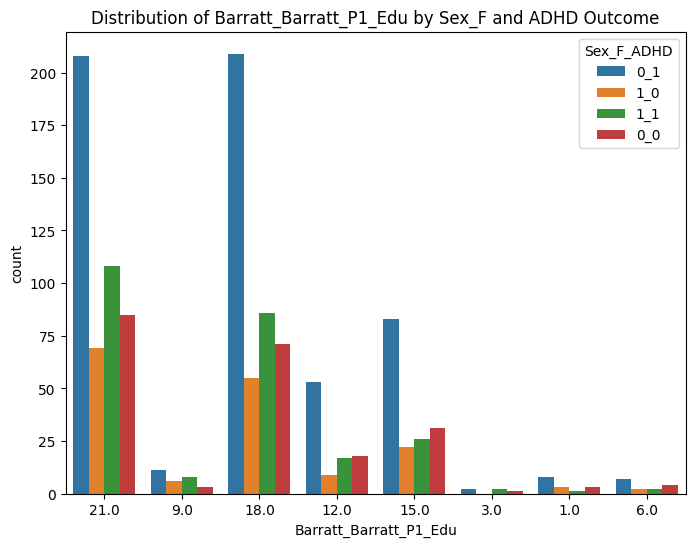

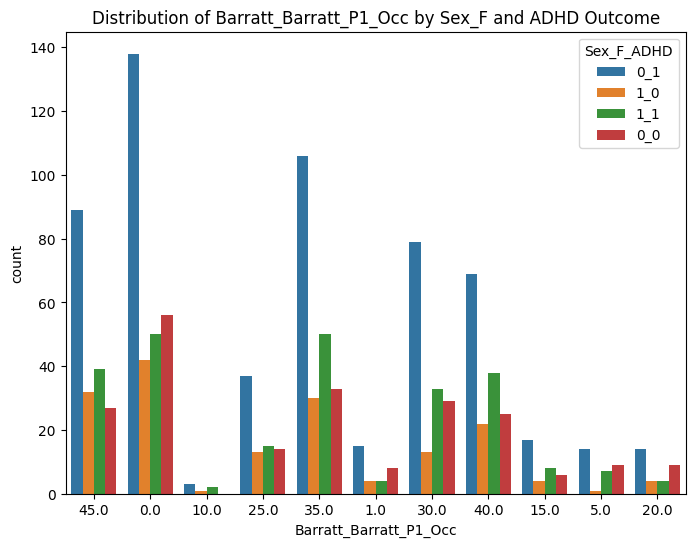

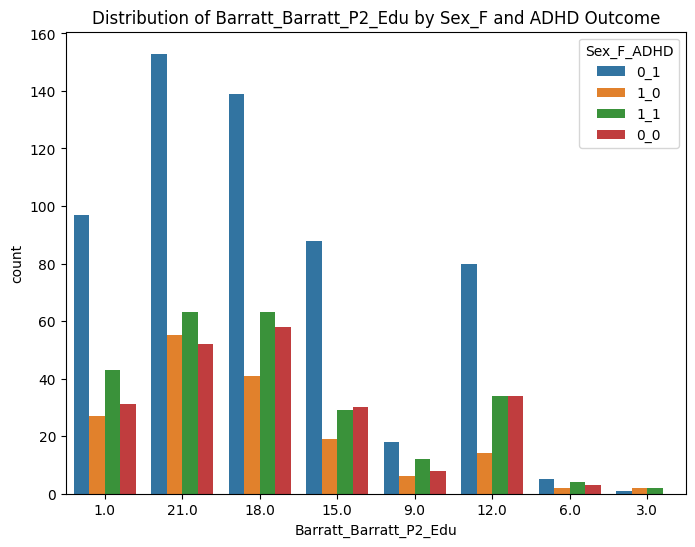

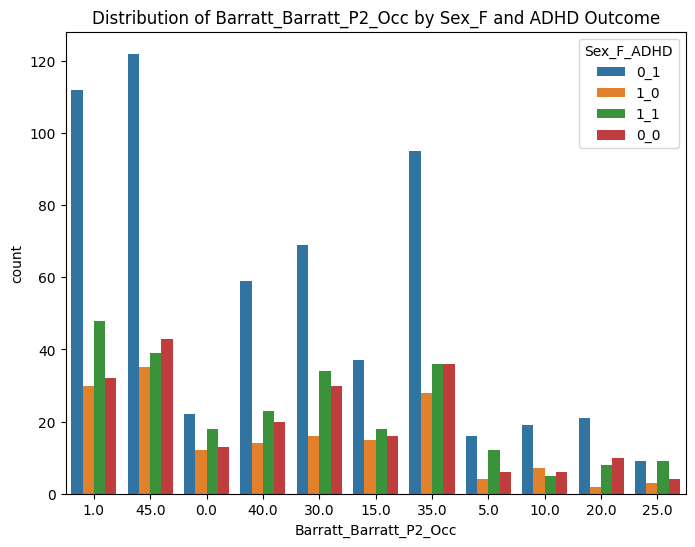

In [36]:
cat_col = df.select_dtypes(exclude=['int64','float64']).columns
cat_col = cat_col[~cat_col.isin(['Sex_F', 'ADHD_Outcome','participant_id','Sex_F_ADHD'])]

for col in cat_col:
    plt.figure(figsize=(8,6))
    sns.countplot(x=df[col],hue='Sex_F_ADHD',data=df)
    plt.title(f"Distribution of {col} by Sex_F and ADHD Outcome")
    plt.show()

We don't need label encoder as all the values in the columns are integer/ float. On the other hand, we are using tree based model and hence we don't need to scale our data.

In [37]:
X = train.drop(columns = ['ADHD_Outcome', 'Sex_F', 'participant_id'])
y = train[['ADHD_Outcome', 'Sex_F']]

In [38]:
X_train, X_test, y_train,y_test = train_test_split(X,y,random_state = 42, stratify = y)

In [39]:
xgb_model = MultiOutputClassifier(xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42))
xgb_model.fit(X_train,y_train)
y_pred = xgb_model.predict(X_test)
print('f1: ', f1_score(y_test,y_pred,average='micro'))

f1:  0.7167832167832168


In [40]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('pca', PCA(n_components=0.95))  # Apply PCA
])

X_train_pca = pca_pipeline.fit_transform(X_train)
X_test_pca = pca_pipeline.transform(X_test)

#train model
xgb_model_pca = MultiOutputClassifier(xgb.XGBClassifier(objective = 'binary:logistic',eval_metric='logloss',random_state = 42))
xgb_model_pca.fit(X_train_pca,y_train)

#prediction
y_pred_pca = xgb_model_pca.predict(X_test_pca)

#Evaluate F1 score
f1_pca = f1_score(y_test,y_pred_pca,average='micro')
print('F1 score with PCA',f1_pca)

F1 score with PCA 0.6979655712050079


In [41]:
#try to use UMAP 

#standardised 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#UMAP
for n in [5,10,20,30,40]:
    umap_reducer = umap.UMAP(n_components=n)
    X_train_umap = umap_reducer.fit_transform(X_train_scaled)
    X_test_umap = umap_reducer.transform(X_test_scaled)

#train model
    xgb_model_umap = MultiOutputClassifier(xgb.XGBClassifier(objective = 'binary:logistic',eval_metric='logloss',random_state = 42))
    xgb_model_umap.fit(X_train_umap,y_train)

    y_pred = xgb_model_umap.predict(X_test_umap)
    print(f'F1 score with {n} components :',f1_score(y_test,y_pred,average='micro'))



F1 score with 5 components : 0.5667752442996743
F1 score with 10 components : 0.6022187004754358
F1 score with 20 components : 0.628482972136223
F1 score with 30 components : 0.5971563981042654
F1 score with 40 components : 0.6091205211726385


Conclusion: The one without PCA and UMAP has highest F1 score. This might cause by the loss of important features as they reduce the number of features, which might remove important information that helping XGboost for better predictions.

In [42]:
test

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,Cfwaf5FX7jWK,2022,4,0.0,0.0,4,21.0,30.0,18.0,30.0,...,0.080423,-0.054581,-0.088163,-0.028574,0.444847,0.350149,-0.012601,0.665750,0.560565,0.555732
1,vhGrzmvA3Hjq,2023,4,0.0,0.0,4,21.0,45.0,1.0,30.0,...,0.198009,-0.000724,0.083122,0.033043,0.687497,0.306229,0.717485,0.461809,0.559632,0.350027
2,ULliyEXjy4OV,2022,4,0.0,0.0,4,21.0,40.0,18.0,40.0,...,0.051319,0.023630,-0.056819,0.117396,0.576086,0.517831,0.527044,0.605038,0.609856,0.750987
3,LZfeAb1xMtql,2022,4,0.0,0.0,3,21.0,45.0,21.0,45.0,...,0.046183,-0.238962,0.121868,-0.260970,0.646818,0.594902,0.608156,0.595459,0.683189,0.542296
4,EnFOUv0YK1RG,2022,4,2.0,0.0,4,18.0,0.0,21.0,45.0,...,0.315734,0.002234,0.290791,0.344149,0.480214,0.539824,0.447322,0.293088,0.148529,0.539823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,UadZfjdEg7eG,2023,4,0.0,0.0,4,18.0,0.0,18.0,35.0,...,0.021524,-0.162832,0.105546,0.028975,0.576180,0.378365,0.399277,0.556115,0.490833,0.568742
300,IUEHiLmQAqCi,2023,4,0.0,1.0,3,18.0,35.0,21.0,40.0,...,0.044974,-0.078047,-0.118271,0.035741,0.640073,0.515096,0.206462,0.536001,0.318518,0.305596
301,cRySmCadYFRO,2023,4,0.0,8.0,4,21.0,25.0,15.0,1.0,...,0.145582,0.004455,0.134574,-0.152951,0.782938,0.737555,0.593972,0.734463,0.680979,0.678973
302,E3MvDUtJadc5,2022,4,0.0,8.0,4,21.0,0.0,21.0,45.0,...,0.036169,-0.345563,-0.165280,-0.347035,0.657024,0.590523,0.094565,0.727339,0.429694,0.530238


In [43]:
sample_submission

,participant_id,ADHD_Outcome,Sex_F
0,Cfwaf5FX7jWK,1,0
1,vhGrzmvA3Hjq,0,0
2,ULliyEXjy4OV,0,1
3,LZfeAb1xMtql,1,0
4,EnFOUv0YK1RG,1,0
...,...,...,...
299,UadZfjdEg7eG,1,0
300,IUEHiLmQAqCi,1,1
301,cRySmCadYFRO,1,0
302,E3MvDUtJadc5,1,0


In [44]:
#save 'id' column for submission
test_ids = test['participant_id']

test_ids

0      Cfwaf5FX7jWK
1      vhGrzmvA3Hjq
2      ULliyEXjy4OV
3      LZfeAb1xMtql
4      EnFOUv0YK1RG
           ...     
299    UadZfjdEg7eG
300    IUEHiLmQAqCi
301    cRySmCadYFRO
302    E3MvDUtJadc5
303    dQJXfyRazknD
Name: participant_id, Length: 304, dtype: object

In [45]:
test = test.drop('participant_id',axis =1)
y_pred_a = xgb_model.predict(test)

output = pd.DataFrame({'participant_id': test_ids,
                       'ADHD_Outcome': y_pred_a[:,0],
                      'Sex_F':y_pred_a[:,1]})

output.to_csv('submission.csv', index=False)